Loading and preprocessing data...
Fraud percentage: 0.1727%
Original dataset shape: (284807, 30)
Splitting dataset...

Genetic Algorithm Configuration:
GA subset size: 32040 samples
Number of features: 30
Population size: 15, Generations: 8

Starting Genetic Algorithm optimization...
gen	nevals	avg     	min     	max     
0  	15    	0.621112	0.499992	0.734058
1  	11    	0.681133	0.516731	0.734058
2  	12    	0.694223	0.567698	0.734058
3  	10    	0.723413	0.697192	0.734058
4  	9     	0.729848	0.67382 	0.734058
5  	12    	0.723035	0.630406	0.734058
6  	10    	0.72185 	0.550948	0.734058
7  	8     	0.721861	0.551105	0.734058
8  	11    	0.734057	0.734049	0.734058
GA optimization completed in 7967.92 seconds

Training final model with best parameters...

Model Evaluation:
Number of selected features: 14/30
Selected features: ['V1', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V14', 'V16', 'V17', 'V18', 'V20', 'V26']
Test AUC: 0.6176

Classification Report:
              precision    recall  f1-

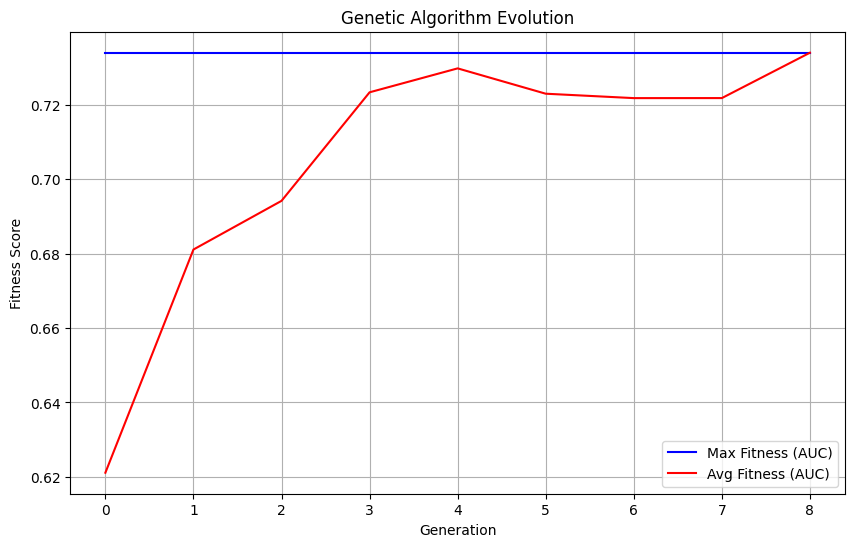


Total execution time: 8770.98 seconds


In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt
import time

def load_and_preprocess():
    df = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/raw/european_data.csv')

    df.fillna(df.median(), inplace=True)

    scaler = StandardScaler()
    df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

    return df

def setup_ga(X_train, y_train):
    n_features = X_train.shape[1]

    if "FitnessMax" not in creator.__dict__:
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    if "Individual" not in creator.__dict__:
        creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()

    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("attr_float", random.uniform, 0, 1)

    def create_individual():
        feature_mask = [toolbox.attr_bool() for _ in range(n_features)]
        hyperparams = [toolbox.attr_float() for _ in range(4)]
        return feature_mask + hyperparams

    toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate(individual):
        try:
            feature_mask = individual[:n_features]
            lr = individual[n_features] * 0.2 + 0.01
            max_depth = int(individual[n_features+1] * 10) + 3
            subsample = individual[n_features+2] * 0.5 + 0.5
            min_samples_split = int(individual[n_features+3] * 90) + 10

            if sum(feature_mask) == 0:
                return (0.0,)

            X_train_sub = X_train.iloc[:, feature_mask]

            model = GradientBoostingClassifier(
                learning_rate=lr,
                max_depth=max_depth,
                subsample=subsample,
                min_samples_split=min_samples_split,
                n_estimators=100,
                random_state=42
            )

            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            auc_scores = []

            for train_idx, val_idx in cv.split(X_train_sub, y_train):
                X_train_fold, X_val_fold = X_train_sub.iloc[train_idx], X_train_sub.iloc[val_idx]
                y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

                model.fit(X_train_fold, y_train_fold)
                y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
                auc_scores.append(roc_auc_score(y_val_fold, y_pred_proba))

            return (np.mean(auc_scores),)
        except Exception as e:
            print(f"Evaluation error: {str(e)}")
            return (0.0,)

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

    return toolbox

def optimize_with_ga(X_train, y_train, population_size=15, generations=8):
    toolbox = setup_ga(X_train, y_train)
    population = toolbox.population(n=population_size)

    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    population, logbook = algorithms.eaSimple(
        population, toolbox,
        cxpb=0.7,
        mutpb=0.25,
        ngen=generations,
        stats=stats,
        verbose=True
    )

    best_individual = tools.selBest(population, k=1)[0]
    return best_individual, logbook

def train_and_evaluate(best_individual, X_train, y_train, X_test, y_test):
    n_features = X_train.shape[1]

    feature_mask = best_individual[:n_features]
    lr = best_individual[n_features] * 0.2 + 0.01
    max_depth = int(best_individual[n_features+1] * 10) + 3
    subsample = best_individual[n_features+2] * 0.5 + 0.5
    min_samples_split = int(best_individual[n_features+3] * 90) + 10

    X_train_selected = X_train.iloc[:, feature_mask]
    X_test_selected = X_test.iloc[:, feature_mask]

    model = GradientBoostingClassifier(
        learning_rate=lr,
        max_depth=max_depth,
        subsample=subsample,
        min_samples_split=min_samples_split,
        n_estimators=300,
        random_state=42
    )

    model.fit(X_train_selected, y_train)

    y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
    y_pred = model.predict(X_test_selected)
    auc = roc_auc_score(y_test, y_pred_proba)

    feature_importance = pd.Series(feature_mask, index=X_train.columns)
    selected_features = feature_importance[feature_importance == 1].index.tolist()

    return auc, model, selected_features, y_pred, y_pred_proba

def main():
    start_time = time.time()

    print("Loading and preprocessing data...")
    df = load_and_preprocess()

    if 'Class' not in df.columns:
        raise ValueError("Dataset does not contain 'Class' column - required for classification")

    X = df.drop('Class', axis=1)
    y = df['Class']

    fraud_percent = y.mean() * 100
    print(f"Fraud percentage: {fraud_percent:.4f}%")
    print(f"Original dataset shape: {X.shape}")

    print("Splitting dataset...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42
    )

    X_ga, _, y_ga, _ = train_test_split(
        X_train, y_train, train_size=0.15, stratify=y_train, random_state=42
    )

    print("\nGenetic Algorithm Configuration:")
    print(f"GA subset size: {X_ga.shape[0]} samples")
    print(f"Number of features: {X_ga.shape[1]}")
    print(f"Population size: 15, Generations: 8")

    print("\nStarting Genetic Algorithm optimization...")
    ga_start = time.time()
    best_individual, logbook = optimize_with_ga(X_ga, y_ga)
    print(f"GA optimization completed in {time.time() - ga_start:.2f} seconds")

    print("\nTraining final model with best parameters...")
    auc, model, selected_features, y_pred, y_pred_proba = train_and_evaluate(
        best_individual, X_train, y_train, X_test, y_test
    )

    print("\nModel Evaluation:")
    print(f"Number of selected features: {len(selected_features)}/{X.shape[1]}")
    print(f"Selected features: {selected_features}")
    print(f"Test AUC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    if logbook:
        gen = logbook.select("gen")
        max_fit = logbook.select("max")
        avg_fit = logbook.select("avg")

        plt.figure(figsize=(10, 6))
        plt.plot(gen, max_fit, 'b-', label="Max Fitness (AUC)")
        plt.plot(gen, avg_fit, 'r-', label="Avg Fitness (AUC)")
        plt.xlabel("Generation")
        plt.ylabel("Fitness Score")
        plt.title("Genetic Algorithm Evolution")
        plt.legend()
        plt.grid(True)
        plt.savefig('ga_evolution.png')
        plt.show()

    print(f"\nTotal execution time: {time.time() - start_time:.2f} seconds")

if __name__ == "__main__":
    main()